# Coffee Bean Classification

### Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from glob import glob 
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")


## Data

### Loading dataset and checking classes

In [2]:
data = pd.read_csv('data\Coffee Bean.csv')
data.head()

,class index,filepaths,labels,data set
0,0,train/Dark/dark (1).png,Dark,train
1,0,train/Dark/dark (10).png,Dark,train
2,0,train/Dark/dark (100).png,Dark,train
3,0,train/Dark/dark (101).png,Dark,train
4,0,train/Dark/dark (102).png,Dark,train


In [3]:
classes = sorted(os.listdir('data/train/'))
print(classes)

photos_per_class = [len(glob('data/train/' + name + '/*.png')) for name in classes]
photos_per_class

['Dark', 'Green', 'Light', 'Medium']


[300, 300, 300, 300]

### Loading images

In [4]:
train_data_generator = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True, 
        width_shift_range = 0.2, 
        height_shift_range = 0.2,
        shear_range = 0.2, 
        zoom_range = 0.2, 
        validation_split=0.3)

test_data_generator = ImageDataGenerator(rescale=1./255)

train_data = train_data_generator.flow_from_directory('data/train/', target_size=(224, 224), shuffle=True, 
                                                       subset='training', class_mode='categorical')
validation_data = train_data_generator.flow_from_directory('data/train/', target_size=(224, 224), shuffle=True, 
                                                       subset='validation', class_mode='categorical')
test_data = train_data_generator.flow_from_directory('data/test/', target_size=(224, 224), shuffle=True, 
                                                       class_mode='categorical')

Found 840 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


### Images from each class in train and test set

In [5]:
def show_image(target, bean_class):
    path = target + bean_class
    image = random.sample(os.listdir(path), 1)
    img = mpimg.imread(path + '/' + image[0])
    plt.imshow(img)
    plt.title(bean_class)
    plt.axis('off')

    return img

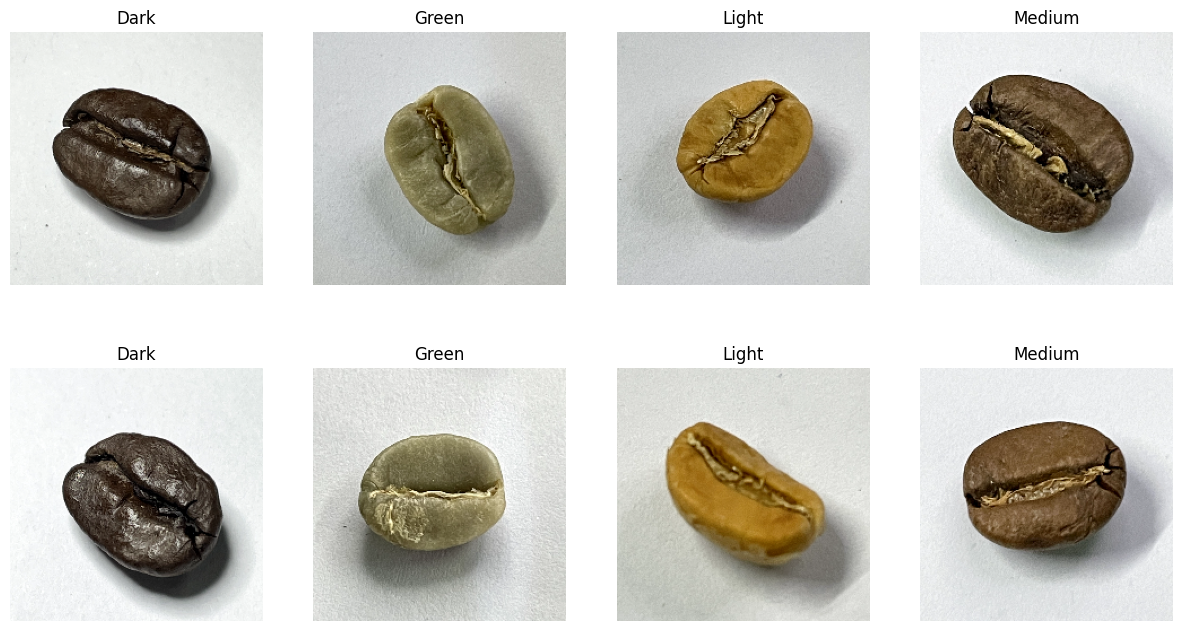

In [6]:
plt.figure(figsize = (15,8))
plt.subplot(2,4,1)
dark_bean_train = show_image('data/train/', 'Dark')
plt.subplot(2,4,2)
green_bean_train = show_image('data/train/', 'Green')
plt.subplot(2,4,3)
light_bean_train = show_image('data/train/', 'Light')
plt.subplot(2,4,4)
medium_bean_train = show_image('data/train/', 'Medium')
plt.subplot(2,4,5)
dark_bean_test = show_image('data/test/', 'Dark')
plt.subplot(2,4,6)
green_bean_test = show_image('data/test/', 'Green')
plt.subplot(2,4,7)
light_bean_test = show_image('data/test/', 'Light')
plt.subplot(2,4,8)
medium_bean_test = show_image('data/test/', 'Medium')

In [7]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

In [9]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [14]:
model.fit(train_data, epochs=20, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=validation_data.samples // 32)

Epoch 1/20
27/27 [==============================] - 10s 366ms/step - loss: 1.6087 - accuracy: 0.3440 - val_loss: 1.1523 - val_accuracy: 0.3949
Epoch 2/20
27/27 [==============================] - 10s 388ms/step - loss: 0.7976 - accuracy: 0.6524 - val_loss: 1.0859 - val_accuracy: 0.4034
Epoch 3/20
27/27 [==============================] - 9s 309ms/step - loss: 0.6046 - accuracy: 0.7750 - val_loss: 0.2051 - val_accuracy: 0.9233
Epoch 4/20
27/27 [==============================] - 8s 277ms/step - loss: 0.5242 - accuracy: 0.8429 - val_loss: 0.2441 - val_accuracy: 0.8977
Epoch 5/20
27/27 [==============================] - 7s 274ms/step - loss: 0.3781 - accuracy: 0.8667 - val_loss: 0.1570 - val_accuracy: 0.9460
Epoch 6/20
27/27 [==============================] - 7s 269ms/step - loss: 0.3477 - accuracy: 0.8929 - val_loss: 0.2340 - val_accuracy: 0.9148
Epoch 7/20
27/27 [==============================] - 7s 269ms/step - loss: 0.3447 - accuracy: 0.9119 - val_loss: 0.3066 - val_accuracy: 0.8778
Epoc

In [15]:
model.evaluate(test_data)

13/13 [==============================] - 3s 198ms/step - loss: 0.0683 - accuracy: 0.9750


[0.06830784678459167, 0.9750000238418579]

In [16]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

In [17]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [18]:
model.fit(train_data, epochs=20, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=int(0.25 * len(validation_data)))

Epoch 1/20
27/27 [==============================] - 7s 232ms/step - loss: 1.4364 - accuracy: 0.2893 - val_loss: 1.4025 - val_accuracy: 0.3438
Epoch 2/20
27/27 [==============================] - 6s 226ms/step - loss: 1.1637 - accuracy: 0.4690 - val_loss: 1.0302 - val_accuracy: 0.4271
Epoch 3/20
27/27 [==============================] - 6s 227ms/step - loss: 0.9325 - accuracy: 0.6083 - val_loss: 0.7804 - val_accuracy: 0.5104
Epoch 4/20
27/27 [==============================] - 6s 226ms/step - loss: 0.6419 - accuracy: 0.7417 - val_loss: 1.1651 - val_accuracy: 0.6146
Epoch 5/20
27/27 [==============================] - 6s 227ms/step - loss: 0.5232 - accuracy: 0.8119 - val_loss: 0.3385 - val_accuracy: 0.9167
Epoch 6/20
27/27 [==============================] - 6s 219ms/step - loss: 0.3955 - accuracy: 0.8381 - val_loss: 0.1989 - val_accuracy: 0.9479
Epoch 7/20
27/27 [==============================] - 6s 222ms/step - loss: 0.4330 - accuracy: 0.8524 - val_loss: 0.2171 - val_accuracy: 0.9062
Epoch 

In [19]:
model.evaluate(test_data)

13/13 [==============================] - 3s 202ms/step - loss: 0.0736 - accuracy: 0.9725


[0.07362920045852661, 0.9725000262260437]